In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# pipeline model
image = skimage.io.imread('Images\dog_test.jpg')
image = skimage.io.imread('Images\eagle.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=9,
                              pixels_per_cell=(8,8),
                              cells_per_block=(3,3))

In [7]:
feature_vector

array([0.01673629, 0.00618719, 0.0491643 , ..., 0.03468617, 0.01951081,
       0.00287858])

In [8]:
import pickle
# load the model
# model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
model = pickle.load(open('MLPClassifierModel_model_best.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [9]:
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 20,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (300, 200, 100),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.0001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}

In [10]:
feature_vector.shape

(5184,)

In [11]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [12]:
scalex.shape

(1, 5184)

In [13]:
result

array(['eagle'], dtype='<U8')

In [14]:
# cal the probabilty 
# decision_value = model.decision_function(scalex)
decision_value = model.predict_proba(scalex)

In [15]:
decision_value

array([[6.69905663e-07, 2.25398430e-05, 3.92068947e-04, 5.06321850e-05,
        5.68076339e-06, 4.59083933e-04, 8.64723562e-03, 9.82095122e-01,
        1.32073325e-06, 1.48727489e-03, 2.51630952e-06, 9.23205759e-04,
        1.72876639e-05, 6.43595159e-07, 6.75358808e-05, 4.93634697e-03,
        1.02482456e-04, 9.55440469e-06, 7.77468981e-04, 1.32882356e-06]])

In [16]:
labels = model.classes_

In [17]:
decision_value = decision_value.flatten()

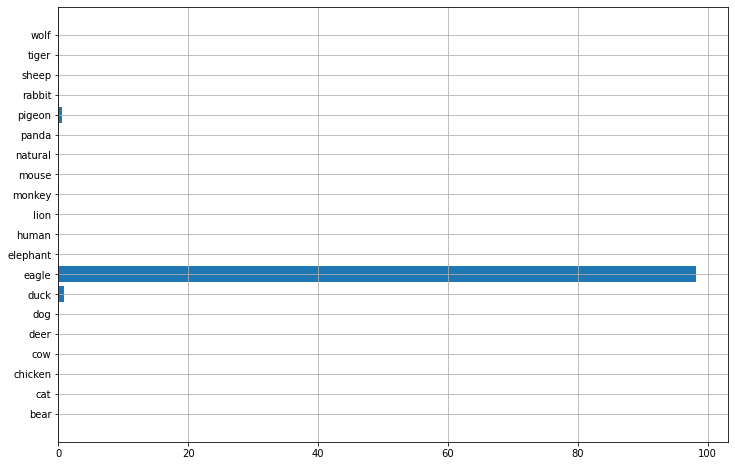

In [34]:
plt.figure(figsize=(12,8))
plt.barh(labels,decision_value*100)
plt.grid()

In [19]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.00848709, 0.00848796, 0.00850264, 0.00848908, 0.00848729,
       0.00850531, 0.00883729, 0.83802542, 0.00848712, 0.0085463 ,
       0.00848717, 0.00852379, 0.00848775, 0.00848709, 0.00848975,
       0.00868526, 0.00849114, 0.00848745, 0.00851798, 0.00848712])

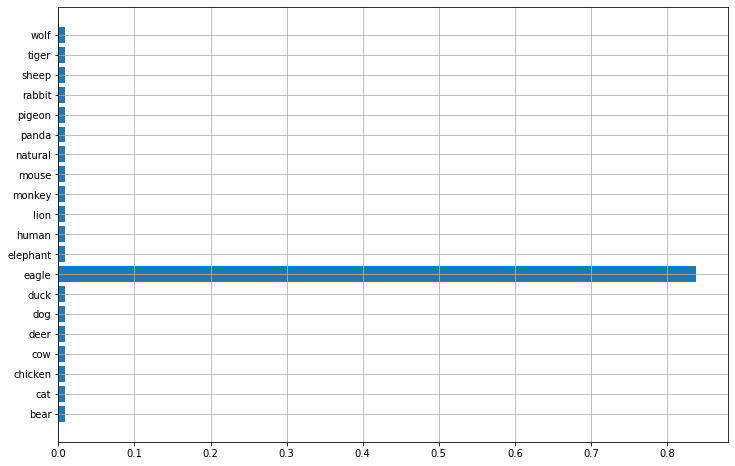

In [20]:
plt.figure(figsize=(12,8))
plt.barh(labels,prob_value)
plt.grid()

In [21]:
labels

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [22]:
prob_value.argsort()

array([13,  0,  8, 19, 10,  4, 17, 12,  1,  3, 14, 16,  2,  5, 18, 11,  9,
       15,  6,  7], dtype=int64)

In [23]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [24]:
top_5_prob_ind

array([ 7,  6, 15,  9, 11], dtype=int64)

In [25]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [26]:
top_prob,top_labels

(array([0.83802542, 0.00883729, 0.00868526, 0.0085463 , 0.00852379]),
 array(['eagle', 'duck', 'pigeon', 'human', 'monkey'], dtype='<U8'))

In [27]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [28]:
top_dict

{'eagle': 0.838,
 'duck': 0.009,
 'pigeon': 0.009,
 'human': 0.009,
 'monkey': 0.009}

In [29]:
def pipeline_model(path, scaler_transform, model_sgd):

    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(   gray,
                                            orientations=9,
                                            pixels_per_cell=(8, 8),
                                            cells_per_block=(3, 3))
    # scaling
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)

    # decision function # confidence
    # decision_value = model_sgd.decision_function(scalex).flatten()
    decision_value = model_sgd.predict_proba(scalex).flatten()
    labels = model_sgd.classes_

    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict

In [30]:
res = pipeline_model('images/eagle.jpg',scaler,model)
res

{'eagle': 0.838,
 'duck': 0.009,
 'pigeon': 0.009,
 'human': 0.009,
 'monkey': 0.009}